# Pump It Up - Data Mining the Water Table  
We take part in the Driven Data competition 'Pump It Up - Data Mining the Water Table' at  
https://www.drivendata.org/competitions/7/pump-it-up-data-mining-the-water-table/page/23/

## Import libraries

In [1]:
import numpy as np
import pandas as pd
import tensorflow as tf
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix
from sklearn.ensemble import RandomForestClassifier

import imblearn
from imblearn.over_sampling import RandomOverSampler
from imblearn.over_sampling import SMOTE
from sklearn.datasets import make_classification

## Load dataset and perform initial checks

In [2]:
df_train_values = pd.read_csv('./training_set_values.csv')
df_train_labels = pd.read_csv('./training_set_labels.csv')
df_test_values = pd.read_csv('./test_set_values.csv')

Check that values and labels datasets have same length

In [3]:
print(df_train_values.shape)
print(df_train_labels.shape)

(59400, 40)
(59400, 2)


Check head of values and labels datasets

In [4]:
df_train_values.head()

,id,amount_tsh,date_recorded,funder,gps_height,installer,longitude,latitude,wpt_name,num_private,...,payment_type,water_quality,quality_group,quantity,quantity_group,source,source_type,source_class,waterpoint_type,waterpoint_type_group
0,69572,6000.0,2011-03-14,Roman,1390,Roman,34.938093,-9.856322,none,0,...,annually,soft,good,enough,enough,spring,spring,groundwater,communal standpipe,communal standpipe
1,8776,0.0,2013-03-06,Grumeti,1399,GRUMETI,34.698766,-2.147466,Zahanati,0,...,never pay,soft,good,insufficient,insufficient,rainwater harvesting,rainwater harvesting,surface,communal standpipe,communal standpipe
2,34310,25.0,2013-02-25,Lottery Club,686,World vision,37.460664,-3.821329,Kwa Mahundi,0,...,per bucket,soft,good,enough,enough,dam,dam,surface,communal standpipe multiple,communal standpipe
3,67743,0.0,2013-01-28,Unicef,263,UNICEF,38.486161,-11.155298,Zahanati Ya Nanyumbu,0,...,never pay,soft,good,dry,dry,machine dbh,borehole,groundwater,communal standpipe multiple,communal standpipe
4,19728,0.0,2011-07-13,Action In A,0,Artisan,31.130847,-1.825359,Shuleni,0,...,never pay,soft,good,seasonal,seasonal,rainwater harvesting,rainwater harvesting,surface,communal standpipe,communal standpipe


In [5]:
df_train_labels.head()

,id,status_group
0,69572,functional
1,8776,functional
2,34310,functional
3,67743,non functional
4,19728,functional


Check that rows have same order among the two df. If all ids match, we should get 0 below:

In [6]:
np.sum(df_train_values['id']-df_train_labels['id'])

0

Check info (names, types, any missing values):

In [7]:
df_train_labels.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 59400 entries, 0 to 59399
Data columns (total 2 columns):
id              59400 non-null int64
status_group    59400 non-null object
dtypes: int64(1), object(1)
memory usage: 928.2+ KB


We observe no missing values for the labels dataset.

In [8]:
df_train_values.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 59400 entries, 0 to 59399
Data columns (total 40 columns):
id                       59400 non-null int64
amount_tsh               59400 non-null float64
date_recorded            59400 non-null object
funder                   55765 non-null object
gps_height               59400 non-null int64
installer                55745 non-null object
longitude                59400 non-null float64
latitude                 59400 non-null float64
wpt_name                 59400 non-null object
num_private              59400 non-null int64
basin                    59400 non-null object
subvillage               59029 non-null object
region                   59400 non-null object
region_code              59400 non-null int64
district_code            59400 non-null int64
lga                      59400 non-null object
ward                     59400 non-null object
population               59400 non-null int64
public_meeting           56066 non-null object
r

We see that some features have missing values. We print out explicitly which features do:

In [9]:
df_train_values.columns[df_train_values.isnull().any()]

Index(['funder', 'installer', 'subvillage', 'public_meeting',
       'scheme_management', 'scheme_name', 'permit'],
      dtype='object')

Finally, print out some basic statistics about numerical features

In [10]:
df_train_values.describe().drop(['id'],axis=1)

,amount_tsh,gps_height,longitude,latitude,num_private,region_code,district_code,population,construction_year
count,59400.000000,59400.000000,59400.000000,5.940000e+04,59400.000000,59400.000000,59400.000000,59400.000000,59400.000000
mean,317.650385,668.297239,34.077427,-5.706033e+00,0.474141,15.297003,5.629747,179.909983,1300.652475
std,2997.574558,693.116350,6.567432,2.946019e+00,12.236230,17.587406,9.633649,471.482176,951.620547
min,0.000000,-90.000000,0.000000,-1.164944e+01,0.000000,1.000000,0.000000,0.000000,0.000000
25%,0.000000,0.000000,33.090347,-8.540621e+00,0.000000,5.000000,2.000000,0.000000,0.000000
50%,0.000000,369.000000,34.908743,-5.021597e+00,0.000000,12.000000,3.000000,25.000000,1986.000000
75%,20.000000,1319.250000,37.178387,-3.326156e+00,0.000000,17.000000,5.000000,215.000000,2004.000000
max,350000.000000,2770.000000,40.345193,-2.000000e-08,1776.000000,99.000000,80.000000,30500.000000,2013.000000


A few comments:  
- 'amount_tsh' seems to have some problems (most of the values are zero and max is much higher than 75th pencentile)
- 'gps_height' looks ok. Altitudes in Tanzania vary between sea level and Mount Kilimanjaro at 5,895m. Since we are talking about wells, a negative value (meaning a well below sea level) still looks reasonable.
- from this website (https://www.worldatlas.com/af/tz/where-is-tanzania.html) we learn that Tanzania is positioned in the latitude range of [-11.75,-0.99] and longitude range of [29.33,40.45]. This means that the min of 'longitude' cannot be correct as well as the max of 'latitude'. The other values look ok.
- from the competition description it's not clear what 'num_private' corresponds to.
- 'region_code' and 'district_code' look ok for all we know.
- the max of 'population' looks like an outlier given the other percentiles.
- 'construction_year' of 0 cannot obviously be correct.

## EDA

Heatmap of the correlations between the numerical features

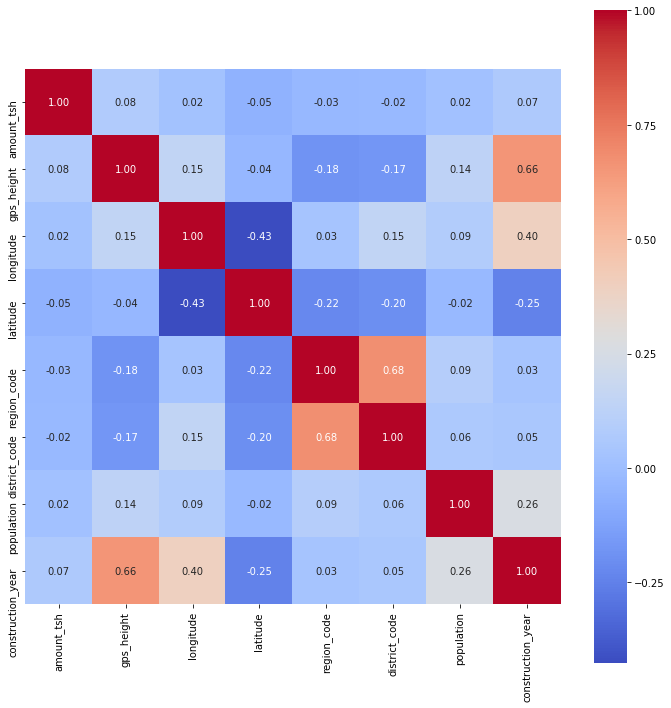

In [11]:
plt.figure(figsize=(12,12))
sns.heatmap(df_train_values.drop(['id','num_private'],axis=1).corr(), square=True, annot=True, fmt='.2f', cmap='coolwarm')
plt.show()

In general we do not observe extremely large positive or negative correlations between features. The feature 'construction_year' seems to be correlated with 'gps_height', indicating that maybe wells located in the mountains were built more recently than wells at lower altitudes (probably easier to build). There also seems to be positive correlation between 'region_code' and 'district_code' which could simply be a consequence of how these codes have been established (we do not have details about them in the competition description). Finally, we observe a mild correlation between 'latitude' and 'longitude' (negative, probably just due to the shape of the country itself, see below) and between 'longitude' and 'construction_year' (positive, indicating that wells were likely built first in the west part of the country and then in the east part).

Scatter plot of latitude and longitude to visualize where the wells are. It's interesting to observe that we reproduce the shape of the country pretty well.

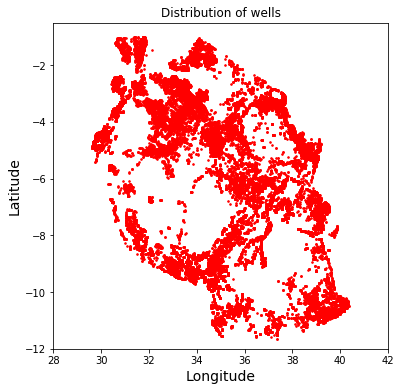

In [12]:
plt.figure(figsize=(6,6))
plt.scatter(df_train_values['longitude'], df_train_values['latitude'], 10, marker='.', c='r')
plt.xlabel('Longitude',size=14)
plt.ylabel('Latitude',size=14)
plt.xlim(28,42)
plt.ylim(-12,-0.5)
plt.title('Distribution of wells')
plt.show()

Check if the train dataset is balanced on the target or not:

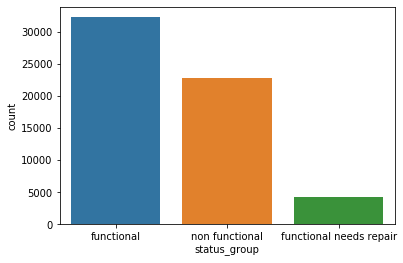

In [13]:
sns.countplot(x='status_group', data=df_train_labels)
plt.show()

In [14]:
df_train_labels['status_group'].value_counts()/len(df_train_labels)

functional                 0.543081
non functional             0.384242
functional needs repair    0.072677
Name: status_group, dtype: float64

We observe that the train set has 54.3% functional wells, 38.4% non-functional wells, and 7.3% functional wells that need repair.

## Data cleaning and pre-processing

### Create train target without one-hot encoding

In [80]:
train_target_nohe = df_train_labels.drop('id',axis=1)

### Create train target with one-hot encoding

In [81]:
train_target_ohe = df_train_labels.copy()
train_target_ohe = pd.get_dummies(train_target_ohe,columns=['status_group'],drop_first=True)
train_target_ohe.drop('id',axis=1, inplace=True)

Check possible target values and what was dropped during one-hot encoding

In [82]:
sorted_target_values = sorted(list(df_train_labels['status_group'].unique()))
print(sorted_target_values)

['functional', 'functional needs repair', 'non functional']


In [83]:
list(train_target_ohe.columns)

['status_group_functional needs repair', 'status_group_non functional']

### Balance dataset

In [19]:
#train_target_nohe_num = train_target_nohe.replace({'functional': 0, 'non functional': 1, 'functional needs repair': 2})

In [20]:
#ros = RandomOverSampler(sampling_strategy='minority')

In [21]:
#X_ros, y_ros = ros.fit_sample(df_train_values.values, np.array(train_target_nohe_num['status_group']))

In [22]:
#df_train_values_ros = pd.DataFrame(X_ros,columns=df_train_values.columns)

In [23]:
#train_target_nohe_ros = pd.DataFrame(y_ros,columns=['status_group'])
#train_target_nohe_ros.replace({0: 'functional', 1:'non functional', 2:'functional needs repair'},inplace=True)

In [24]:
#sns.countplot(x='status_group', data=train_target_nohe_ros)
#plt.show()

In [44]:
# X, y = make_classification(
#     n_classes=3, class_sep=1.5, weights=[0.7, 0.2, 0.1],
#     n_informative=3, n_redundant=1, flip_y=0,
#     n_features=20, n_clusters_per_class=1,
#     n_samples=100, random_state=10
# )
#smote = SMOTE()
#X_sm, y_sm = smote.fit_sample(X, y)

### Work on features (approach #1)

In [ ]:
df_train_preprocessed = df_train_values.copy()
df_test_preprocessed = df_test_values.copy()

### Work on features (approach #2)

In [84]:
df_train_preprocessed = df_train_values.copy()
df_test_preprocessed = df_test_values.copy()

Drop features with no predictive power (such as 'id', 'date_recorded' etc), copies of other features (such as 'region', 'scheme_name' etc), or features with many unique values (such as 'funder', 'installer' etc)

In [85]:
columns_to_drop = ['id','date_recorded','wpt_name','num_private','recorded_by'] + \
                  ['region','scheme_name','scheme_management','management_group','extraction_type_class',
                   'extraction_type_group','payment_type','quality_group','quantity_group',
                   'source_type','source_class','waterpoint_type_group'] + \
                  ['funder','installer','subvillage','lga','ward']

In [86]:
df_train_preprocessed.drop(columns_to_drop,axis=1, inplace=True)
df_test_preprocessed.drop(columns_to_drop,axis=1, inplace=True)

In [87]:
df_train_preprocessed.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 59400 entries, 0 to 59399
Data columns (total 18 columns):
amount_tsh           59400 non-null float64
gps_height           59400 non-null int64
longitude            59400 non-null float64
latitude             59400 non-null float64
basin                59400 non-null object
region_code          59400 non-null int64
district_code        59400 non-null int64
population           59400 non-null int64
public_meeting       56066 non-null object
permit               56344 non-null object
construction_year    59400 non-null int64
extraction_type      59400 non-null object
management           59400 non-null object
payment              59400 non-null object
water_quality        59400 non-null object
quantity             59400 non-null object
source               59400 non-null object
waterpoint_type      59400 non-null object
dtypes: float64(3), int64(5), object(10)
memory usage: 8.2+ MB


Convert 'region_code' and 'district_code' to strings since they're not really numerical

In [88]:
df_train_preprocessed['region_code'] = df_train_preprocessed['region_code'].astype(str)
df_train_preprocessed['district_code'] = df_train_preprocessed['district_code'].astype(str)

df_test_preprocessed['region_code'] = df_test_preprocessed['region_code'].astype(str)
df_test_preprocessed['district_code'] = df_test_preprocessed['district_code'].astype(str)

The zeroes in 'amount_tsh', 'gps_height', 'population', and 'construction_year' are probably there to indicate missing values. We substitute them with the respective medians

In [89]:
amount_tsh_zero = df_train_preprocessed['amount_tsh'] == 0.0
gps_height_zero = df_train_preprocessed['gps_height'] == 0
population_zero = df_train_preprocessed['population'] == 0
construction_year_zero = df_train_preprocessed['construction_year'] == 0

amount_tsh_median = df_train_preprocessed[~amount_tsh_zero]['amount_tsh'].median()
gps_height_median = int(df_train_preprocessed[~gps_height_zero]['gps_height'].median())
population_median = int(df_train_preprocessed[~population_zero]['population'].median())
construction_year_median = int(df_train_preprocessed[~construction_year_zero]['construction_year'].median())

In [90]:
df_train_preprocessed['amount_tsh'].replace(0.0,amount_tsh_median,inplace=True)
df_train_preprocessed['gps_height'].replace(0,gps_height_median,inplace=True)
df_train_preprocessed['population'].replace(0,population_median,inplace=True)
df_train_preprocessed['construction_year'].replace(0,construction_year_median,inplace=True)

df_test_preprocessed['amount_tsh'].replace(0.0,amount_tsh_median,inplace=True)
df_test_preprocessed['gps_height'].replace(0,gps_height_median,inplace=True)
df_test_preprocessed['population'].replace(0,population_median,inplace=True)
df_test_preprocessed['construction_year'].replace(0,construction_year_median,inplace=True)

We know that Tanzania has latitude [-11.75,-0.99] and longitude [29.33,40.45] so we replace values outside of these ranges with averages

In [91]:
train_longitude_outside = (df_train_preprocessed['longitude'] < 29.33) | (df_train_preprocessed['longitude'] > 40.45)
train_latitude_outside = (df_train_preprocessed['latitude'] < -11.75) | (df_train_preprocessed['latitude'] > -0.99)

test_longitude_outside = (df_test_preprocessed['longitude'] < 29.33) | (df_test_preprocessed['longitude'] > 40.45)
test_latitude_outside = (df_test_preprocessed['latitude'] < -11.75) | (df_test_preprocessed['latitude'] > -0.99)

longitude_mean = df_train_preprocessed[~train_longitude_outside]['longitude'].mean()
latitude_mean = df_train_preprocessed[~train_latitude_outside]['latitude'].mean()

In [92]:
df_train_preprocessed['longitude'] = df_train_preprocessed['longitude'].mask(train_longitude_outside,longitude_mean)
df_train_preprocessed['latitude'] = df_train_preprocessed['latitude'].mask(train_latitude_outside,latitude_mean)

df_test_preprocessed['longitude'] = df_test_preprocessed['longitude'].mask(test_longitude_outside,longitude_mean)
df_test_preprocessed['latitude'] = df_test_preprocessed['latitude'].mask(test_latitude_outside,latitude_mean)

The 'unknown' in 'management', 'payment', 'water_quality', 'quantity', and 'source' are essentially missing values. We replace them with respective modes.

In [93]:
df_train_preprocessed['management'].replace('unknown',df_train_preprocessed['management'].mode()[0],inplace=True)
df_train_preprocessed['payment'].replace('unknown',df_train_preprocessed['payment'].mode()[0],inplace=True)
df_train_preprocessed['water_quality'].replace('unknown',df_train_preprocessed['water_quality'].mode()[0],inplace=True)
df_train_preprocessed['quantity'].replace('unknown',df_train_preprocessed['quantity'].mode()[0],inplace=True)
df_train_preprocessed['source'].replace('unknown',df_train_preprocessed['source'].mode()[0],inplace=True)

df_test_preprocessed['management'].replace('unknown',df_train_preprocessed['management'].mode()[0],inplace=True)
df_test_preprocessed['payment'].replace('unknown',df_train_preprocessed['payment'].mode()[0],inplace=True)
df_test_preprocessed['water_quality'].replace('unknown',df_train_preprocessed['water_quality'].mode()[0],inplace=True)
df_test_preprocessed['quantity'].replace('unknown',df_train_preprocessed['quantity'].mode()[0],inplace=True)
df_test_preprocessed['source'].replace('unknown',df_train_preprocessed['source'].mode()[0],inplace=True)

Fill missing values in both train and test sets using mode imputation from train set

In [94]:
fill_missing_values = {'public_meeting': df_train_preprocessed['public_meeting'].mode()[0],
                       'permit': df_train_preprocessed['permit'].mode()[0]}

df_train_preprocessed.fillna(fill_missing_values,inplace=True)
df_test_preprocessed.fillna(fill_missing_values,inplace=True)

In [95]:
df_train_preprocessed.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 59400 entries, 0 to 59399
Data columns (total 18 columns):
amount_tsh           59400 non-null float64
gps_height           59400 non-null int64
longitude            59400 non-null float64
latitude             59400 non-null float64
basin                59400 non-null object
region_code          59400 non-null object
district_code        59400 non-null object
population           59400 non-null int64
public_meeting       59400 non-null bool
permit               59400 non-null bool
construction_year    59400 non-null int64
extraction_type      59400 non-null object
management           59400 non-null object
payment              59400 non-null object
water_quality        59400 non-null object
quantity             59400 non-null object
source               59400 non-null object
waterpoint_type      59400 non-null object
dtypes: bool(2), float64(3), int64(3), object(10)
memory usage: 7.4+ MB


### Standardize numerical features

First define categorial features

In [96]:
categorical_features = list(df_train_preprocessed.select_dtypes(exclude=["number"]).columns)

Create StandardScaler using only train set (to avoid any information leakage from test set) and apply it to both train and test sets

In [97]:
train_scaled_inputs = df_train_preprocessed.copy()
train_num_features = train_scaled_inputs.drop(categorical_features,axis=1)
train_num_features_col = train_num_features.columns.values

scaler = StandardScaler()
scaler.fit(train_num_features.values)

train_num_features = scaler.transform(train_num_features.values)
train_scaled_inputs[train_num_features_col] = train_num_features

In [98]:
test_scaled_inputs = df_test_preprocessed.copy()
test_num_features = test_scaled_inputs.drop(categorical_features,axis=1)
test_num_features_col = test_num_features.columns.values

test_num_features = scaler.transform(test_num_features.values)
test_scaled_inputs[test_num_features_col] = test_num_features

### Create dummy variables for categorical features

Concatenate train and test set and get dummies from the concatenated set to include all possible dummies. Then split again into the two sets. There is no information leakage from the test set because this is simply to obtain the same columns and the same one-hot encodings in the two dataframes.

In [99]:
train_len = len(train_scaled_inputs)
train_test_scaled_inputs = pd.concat([train_scaled_inputs,test_scaled_inputs])

train_test_scaled_inputs = pd.get_dummies(train_test_scaled_inputs,columns=categorical_features,drop_first=True)

train_scaled_inputs, test_scaled_inputs = train_test_scaled_inputs.iloc[:train_len,:], train_test_scaled_inputs.iloc[train_len:,:]

### Train-validation split

In [224]:
x_train, x_val, y_train, y_val = train_test_split(train_scaled_inputs,train_target_nohe, test_size = 0.2, random_state = 42)

## Modeling using a Random Forest Classifier

In [225]:
rf = RandomForestClassifier(n_estimators = 100, max_depth = 18, max_features=40, n_jobs=-1, random_state = 42)
rf.fit(x_train,y_train.values.ravel())

RandomForestClassifier(bootstrap=True, ccp_alpha=0.0, class_weight=None,
                       criterion='gini', max_depth=18, max_features=40,
                       max_leaf_nodes=None, max_samples=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=1, min_samples_split=2,
                       min_weight_fraction_leaf=0.0, n_estimators=100,
                       n_jobs=-1, oob_score=False, random_state=42, verbose=0,
                       warm_start=False)

Train set score and confusion matrix

In [226]:
rf.score(x_train,y_train)

0.9097011784511785

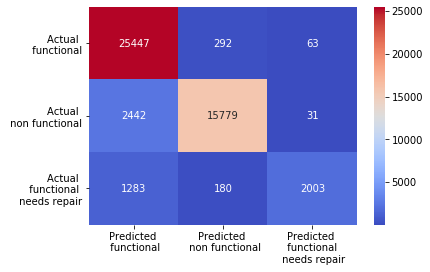

In [227]:
y_train_rf_pred = rf.predict(x_train)

cm_train_rf = confusion_matrix(y_train, y_train_rf_pred,labels=['functional','non functional','functional needs repair'])
cm_train_rf_pd = pd.DataFrame(data=cm_train_rf,columns=['Predicted \n functional','Predicted \n non functional','Predicted \n functional \n needs repair'],index=['Actual \n functional', 'Actual \n non functional', 'Actual \n functional \n needs repair'])
sns.heatmap(cm_train_rf_pd, annot=True, fmt='d', cmap='coolwarm')
plt.show()

Validation set score and confusion matrix

In [228]:
rf.score(x_val,y_val)

0.8057239057239057

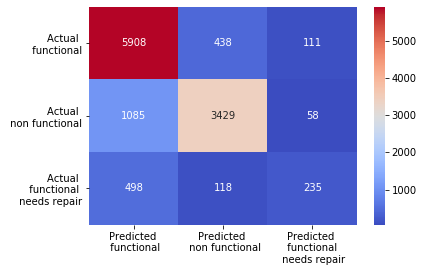

In [229]:
y_val_rf_pred = rf.predict(x_val)

cm_val_rf = confusion_matrix(y_val, y_val_rf_pred,labels=['functional','non functional','functional needs repair'])
cm_val_rf_pd = pd.DataFrame(data=cm_val_rf,columns=['Predicted \n functional','Predicted \n non functional','Predicted \n functional \n needs repair'],index=['Actual \n functional', 'Actual \n non functional', 'Actual \n functional \n needs repair'])
sns.heatmap(cm_val_rf_pd, annot=True, fmt='d', cmap='coolwarm')
plt.show()

## Modeling using an XGBClassifier

In [48]:
import xgboost as xgb

In [162]:
xgb_model = xgb.XGBClassifier(objective='multi:softprob', n_estimators=200, max_depth=20, random_state=42)
xgb_model.fit(x_train,y_train.values.ravel())

XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
              colsample_bynode=1, colsample_bytree=1, gamma=0,
              learning_rate=0.1, max_delta_step=0, max_depth=18,
              min_child_weight=1, missing=None, n_estimators=64, n_jobs=1,
              nthread=None, objective='multi:softprob', random_state=42,
              reg_alpha=0, reg_lambda=1, scale_pos_weight=1, seed=None,
              silent=None, subsample=1, verbosity=1)

In [163]:
xgb_model.score(x_train,y_train)

0.9685185185185186

In [164]:
xgb_model.score(x_val,y_val)

0.8031986531986532

In [160]:
confusion_matrix(y_val,xgb_model.predict(x_val))

array([[5664,  205,  588],
       [ 442,  295,  114],
       [ 904,   81, 3587]])

## Testing

### Obtain predictions from model on test set

In [107]:
y_test_rf_pred = rf.predict(test_scaled_inputs)

### Create csv file for submission

In [108]:
df_submission = df_test_values[['id']].copy()

Go from one-hot encoding back to categorical label

In [109]:
df_submission['status_group'] = y_test_rf_pred

In [110]:
df_submission.head()

,id,status_group
0,50785,non functional
1,51630,functional
2,17168,functional
3,45559,non functional
4,49871,functional


Create output file

In [111]:
df_submission.to_csv('test_predictions.csv', index=False)